In [36]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

#### Get mean ALK over the last IAF cycle for 003 run

In [37]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means.nc'
cesm_ann_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

### and for the 2x run

In [40]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alk_pd004.nc'
cesm_ann_ds2x=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

### other setup

In [42]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [43]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [44]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

## Vertically integrate alkalinity

In [45]:
dz_m=cesm_ann_ds.dz * 0.01
area_m = area * 1.e-4

In [46]:
alk_vert_int = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()

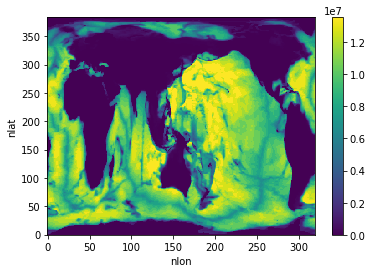

In [47]:
alk_vert_int.plot() #in mmol m-2

In [48]:
alk_vert_int_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_ALT_CO2'], weights=dz_m, dim=['z_t']).compute()
alk_vert_int_2xGCB = esmlab.weighted_sum(cesm_ann_ds2x['ALK_ALT_CO2'], weights=dz_m, dim=['z_t']).compute()

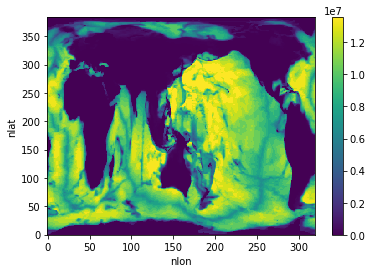

In [49]:
alk_vert_int_noGCB.plot()

In [50]:
alk_vert_int_noGCBdiff = alk_vert_int_noGCB - alk_vert_int
alk_vert_int_noGCBdiff = alk_vert_int_noGCBdiff / 1000.

alk_vert_int_2xGCBdiff = alk_vert_int_2xGCB - alk_vert_int
alk_vert_int_2xGCBdiff = alk_vert_int_2xGCBdiff / 1000.

#### Shows SO alkalinity trap with vertical integration

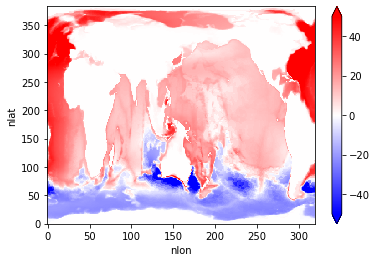

In [51]:
alk_vert_int_noGCBdiff.plot(vmin=-50,vmax=50,cmap='bwr')

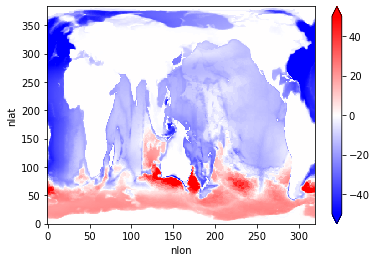

In [52]:
alk_vert_int_2xGCBdiff.plot(vmin=-50,vmax=50,cmap='bwr')

### Let's look vertically with horizontal integration

In [18]:
alk_diff_SO = cesm_ann_ds.ALK_ALT_CO2.where(cesm_ann_ds.TLAT<-45) - cesm_ann_ds.ALK.where(cesm_ann_ds.TLAT<-45)
alk_diff_SO = alk_diff_SO / 1000. #convert to mol/m3

alk_diff_SO2x = cesm_ann_ds2x.ALK_ALT_CO2.where(cesm_ann_ds2x.TLAT<-45) - cesm_ann_ds2x.ALK.where(cesm_ann_ds2x.TLAT<-45)
alk_diff_SO2x = alk_diff_SO2x / 1000. #convert to mol/m3

In [19]:
alk_diff_glb = cesm_ann_ds.ALK_ALT_CO2 - cesm_ann_ds.ALK
alk_diff_glb = alk_diff_glb / 1000. #convert to mol/m3

alk_diff_glb2x = cesm_ann_ds2x.ALK_ALT_CO2 - cesm_ann_ds2x.ALK
alk_diff_glb2x = alk_diff_glb2x / 1000. #convert to mol/m3

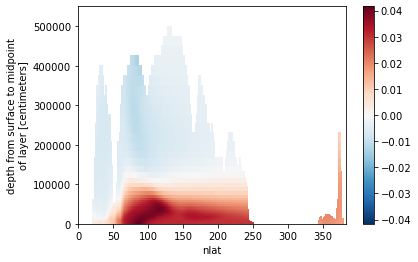

In [20]:
alk_diff_glb.isel(nlon=100).plot()

In [21]:
Alk_SO_horiz_int = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
Alk_SO_horiz_int = esmlab.weighted_sum(alk_diff_SO, weights=area_m, dim=['nlon','nlat']).compute()

Alk_SO_horiz_int2x = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
Alk_SO_horiz_int2x = esmlab.weighted_sum(alk_diff_SO2x, weights=area_m, dim=['nlon','nlat']).compute()

In [22]:
Alk_glb_horiz_int = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
Alk_glb_horiz_int = esmlab.weighted_sum(alk_diff_glb, weights=area_m, dim=['nlon','nlat']).compute()

Alk_glb_horiz_int2x = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
Alk_glb_horiz_int2x = esmlab.weighted_sum(alk_diff_glb2x, weights=area_m, dim=['nlon','nlat']).compute()

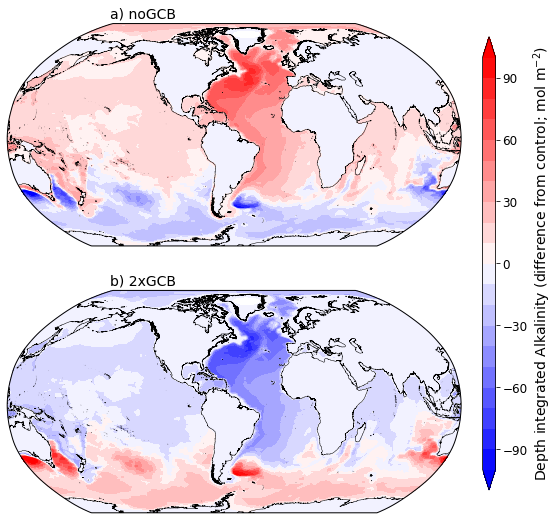

In [24]:
 fig = plt.figure(figsize=(12,9))
contour_specs = {'levels': [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0.,10,20,30,40,50,60,70,80,90,100,]}

#plt.suptitle('Vertically integrated difference in alkalinity',fontsize=14)

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_vert_int_noGCBdiff)
ax.set_title('a) noGCB', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_vert_int_2xGCBdiff)
ax.set_title('b) 2xGCB', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

fig.subplots_adjust(right=0.8,wspace=0.2)
cbar_ax = fig.add_axes([0.75, 0.16, 0.015, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax,extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Depth integrated Alkalinity (difference from control; mol m$^{-2}$)', size=14)
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Alk_zint_diff_maps.pdf', bbox_inches='tight', format='pdf');
